<a href="https://colab.research.google.com/github/joaobezcerra/MetricLearning/blob/main/MetricLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install faiss-cpu

In [14]:
import tensorflow as tf
import numpy as np
import os
import sqlite3
import zipfile
import faiss
import matplotlib.pyplot as plt

In [15]:
def create_db():
    con = sqlite3.connect("database.db")
    return con

con = create_db()
cur = con.cursor()

cur.execute("""
    CREATE TABLE IF NOT EXISTS person (
        person_id INTEGER PRIMARY KEY,
        person_name TEXT
    )
""")

cur.execute("""
    CREATE TABLE IF NOT EXISTS embedding (
        person_id INTEGER,
        embedding TEXT,
        FOREIGN KEY(person_id) REFERENCES person(person_id)
    )
""")
con.commit()

In [16]:
zip_path = "/content/post-processed.zip"
extract_path = "/content/data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data/post-processed",
    batch_size=32,
    shuffle=True,
    image_size=(112, 112)
)

Found 12000 files belonging to 2996 classes.


In [18]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(112, 112, 3)
)

embedding_size = 128

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
embedding_layer = tf.keras.layers.Dense(embedding_size, activation=None)(x)
model = tf.keras.Model(inputs=base_model.input, outputs=embedding_layer)

model.compile(optimizer='adam', loss='mse')
model.summary()

<ipython-input-18-0a0ce289cbd6>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 56, 56,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 56, 56,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 56, 56,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 56, 56,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 56, 56,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 56, 56,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 57, 57,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 28, 28,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 28, 28,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 28, 28,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 28, 28,    │      2,304 │ block_1_depthwis

 Total params: 2,421,952 (9.24 MB)

 Trainable params: 2,387,840 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [19]:
from collections import defaultdict
embedding_database = defaultdict(list)

class_names = dataset.class_names

for images, labels in dataset:
    embeddings = model.predict(images)
    labels_numpy = labels.numpy()
    for emb, label in zip(embeddings, labels_numpy):
        person_name = class_names[label]
        embedding_database[person_name].append(emb)

person_names = []
embeddings_list = []
for person, emb_list in embedding_database.items():
    emb_avg = np.mean(np.array(emb_list), axis=0)
    cur.execute("INSERT INTO person (person_name) VALUES (?)", (person,))
    person_id = cur.lastrowid
    embedding_str = np.array2string(emb_avg, separator=',')
    cur.execute("INSERT INTO embedding (person_id, embedding) VALUES (?, ?)", (person_id, embedding_str))
    person_names.append(person)
    embeddings_list.append(emb_avg)

con.commit()

embeddings_array = np.vstack(embeddings_list).astype(np.float32)

index = faiss.IndexFlatL2(embedding_size)
index.add(embeddings_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [20]:
def preprocess_image(img_path):
    image = tf.keras.utils.load_img(img_path, target_size=(112,112))
    image = tf.keras.utils.img_to_array(image)
    image = image / 255.0
    return image

def extract_embedding(img_path):
    img = preprocess_image(img_path)
    img = tf.expand_dims(img, axis=0)
    emb = model.predict(img)
    return emb.flatten()

In [21]:
new_person_name = "marcelinho_no_db"
new_person_image_path = "/content/marcelinho_no_db.jpg"

In [22]:
new_embedding = extract_embedding(new_person_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


In [23]:
cur.execute("INSERT INTO person (person_name) VALUES (?)", (new_person_name,))
person_id = cur.lastrowid

embedding_str = np.array2string(new_embedding, separator=',')
cur.execute("INSERT INTO embedding (person_id, embedding) VALUES (?, ?)", (person_id, embedding_str))
con.commit()

In [24]:
person_names.append(new_person_name)

index.add(np.array([new_embedding], dtype=np.float32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


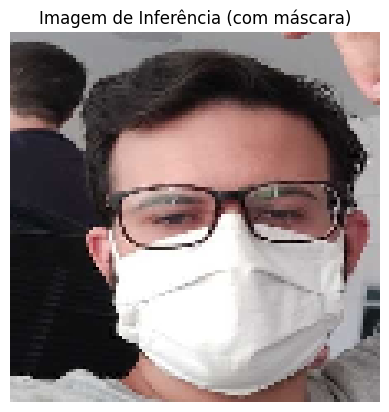

Pessoa reconhecida: marcelinho_no_db
Score da métrica (distância L2): 471.95660400390625


In [25]:
masked_image_path = "/content/marcelinho_na_inferencia.jpg"
masked_embedding = extract_embedding(masked_image_path)

img_inferencia = preprocess_image(masked_image_path)
plt.imshow(img_inferencia)
plt.title("Imagem de Inferência (com máscara)")
plt.axis("off")
plt.show()

D, I = index.search(np.array([masked_embedding], dtype=np.float32), 1)

matched_index = I[0][0]
score = D[0][0]
matched_person = person_names[matched_index]

print(f"Pessoa reconhecida: {matched_person}")
print(f"Score da métrica (distância L2): {score}")